# All experiments on Unsupervised (non-labeled) Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import warnings
warnings.filterwarnings('ignore')

%matplotlib notebook
%matplotlib inline

In [2]:
## Preprocessing Data

In [3]:
hasLabel = False

df = pd.read_csv("data/Talus_Karakorum.csv", sep=';') # Talus_Syene - Talus_london_Soay

df.head(10)

,Context,Layer,Finding,Species,Bone,Dating,GLl,Bd,GLm,Dl
0,EZ Wall-10,NaN,3B6103,Ovis,Talus,NaN,31.2,19.70,31.00,18.0
1,EZ Wall-10,NaN,3B6103,Ovis,Talus,NaN,30.1,19.25,29.15,17.0
2,EZ Wall-11,NaN,3B6103,Ovis,Talus,NaN,32.5,20.80,31.00,18.0
3,EZ Wall-13,NaN,UB6103,Ovis,Talus,NaN,30.6,20.00,28.50,18.0
4,EZ Wall-8,NaN,2B6103,Ovis,Talus,NaN,32.0,22.20,30.30,17.7
5,HD 03-81,NaN,2B4122,Ovis,Talus,NaN,31.5,21.00,30.50,18.0
6,HD 04-47,NaN,B4003,Ovis,Talus,NaN,30.6,20.20,30.20,17.7
7,HD 04-99,NaN,2B4011,Ovis,Talus,NaN,31.5,20.20,30.00,NaN
8,HD 05-62,NaN,2B4011a,Ovis,Talus,NaN,32.7,20.50,30.20,17.8
9,HD 11-46,NaN,3,Ovis,Talus,NaN,28.5,19.50,28.00,15.5


In [4]:
def clean_df(df, columns, target, name_male, name_female):
    X = df[columns].astype(float)
    X = pd.concat([X, df[target]], axis=1)
    X = X.dropna(axis=0).reset_index(drop=True)
    X = X.replace(to_replace=name_male, value='1').replace(to_replace=name_female, value='0').replace(to_replace='c', value='1')

    label = X[target]

    X = X.drop(target, axis=1)
    
    return X, label

In [5]:
col_talus = ['GLl', 'GLm', 'Dl', 'Bd']

if hasLabel:
    X, y = clean_df(df, col_talus, ['Sex'], 'm', 'f')
else:
    X = df[col_talus].astype(float)
    X = X.dropna(axis=0).reset_index(drop=True)
    y = []

In [6]:
print(X[:5])
print(f"Number of samples used: {len(X)}")
print(f"Dimensions of 'label': {len(y)}")

    GLl    GLm    Dl     Bd
0  31.2  31.00  18.0  19.70
1  30.1  29.15  17.0  19.25
2  32.5  31.00  18.0  20.80
3  30.6  28.50  18.0  20.00
4  32.0  30.30  17.7  22.20
Number of samples used: 171
Dimensions of 'label': 0


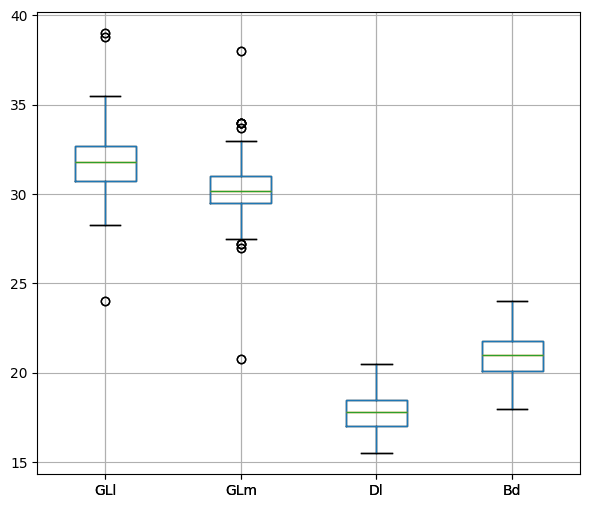

In [7]:
plt.rcParams['figure.figsize'] = [7, 6]

fig1, ax1 = plt.subplots()
ax1.set_title('')
ax1.boxplot(X)
boxplot = X.boxplot(column=col_talus)

fig1.savefig('Karakorum-boxplot.pdf', bbox_inches='tight')

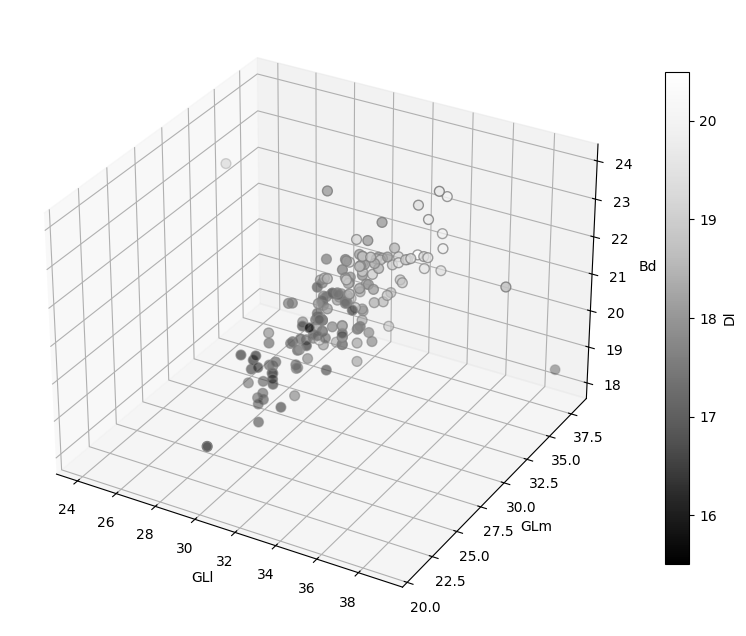

In [8]:
plt.rcParams['figure.figsize'] = [10, 8]

if hasLabel:
    df_f = df.loc[df['Sex'] == 'f']
    df_m = df.loc[df['Sex'] == 'm']

pltx = 'GLl'
plty = 'GLm'
pltz = 'Bd'
pltq = 'Dl'

fig = plt.figure()
ax = plt.axes(projection ="3d")

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

my_cmap = plt.get_cmap('Greys_r')

if hasLabel:
    sctt = ax.scatter3D(df_m[pltx], df_m[plty], df_m[pltz], c = df_m[pltq], cmap = my_cmap, marker='o', edgecolors='tab:blue', linewidth=1.3, s=50, label = 'Syene Male')
    sctt = ax.scatter3D(df_f[pltx], df_f[plty], df_f[pltz], c = df_f[pltq], cmap = my_cmap, marker='X', edgecolors='tab:red', linewidth=1.3, s=50, label = 'Syene Female')
else:
    sctt = ax.scatter3D(df[pltx], df[plty], df[pltz], c = df[pltq], cmap = my_cmap, marker='o', edgecolors='grey', s=50)

#plt.title("")
ax.set_xlabel(pltx)
ax.set_ylabel(plty)
ax.set_zlabel(pltz)
if hasLabel:
    ax.legend(bbox_to_anchor=(1, 0.92), bbox_transform=ax.transAxes)

fig.colorbar(sctt, ax = ax, shrink = 0.8, label = pltq)
fig.savefig('Karakorum-Plot-3D.pdf', bbox_inches='tight')

plt.show()

In [9]:
from sklearn.metrics.cluster import adjusted_rand_score

## Unsupervised Methods

### GMM

In [10]:
from sklearn.mixture import GaussianMixture

def perform_GMM(X_train, y_train, n, X_test=[], y_test=[]):

    gmm = GaussianMixture(n_components=n).fit(X_train)
    
    if len(X_test)==0 or len(y_test)==0:
        y_pred = -1
        acc = -1
    else:
        y_pred = gmm.predict(X_test).astype(str)
        acc = check_acc(y_test, y_pred, unsup=True)
    return gmm, y_pred, acc

In [11]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2).fit(X)
gmm_classes = gmm.predict(X)
print(gmm_classes)

gmm_out = pd.DataFrame({'Outlier' : gmm_classes}).replace(to_replace=1, value=-1)
#print(gmm_out)

X_clusters = pd.concat([X.reset_index(), gmm_out], axis=1)

X_klein = X_clusters.loc[X_clusters['Outlier'] != -1][['GLl', 'GLm', 'Dl', 'Bd']]
#print(len(X_klein))

gmm2 = GaussianMixture(n_components=2).fit(X_klein)
gmm2_classes = gmm2.predict(X_klein)
#print(gmm2_classes)

gmm_labels = pd.DataFrame({'Label' : gmm2_classes})
#print(gmm_labels)

X_clusters = pd.merge(X_clusters, gmm_labels, left_index=True, right_index=True)
X_clusters['Cluster'] = X_clusters.loc[:,['Outlier','Label']].sum(axis=1)
X_clusters
#ari = adjusted_rand_score(y.to_numpy().flatten().astype(int), gmm_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


,index,GLl,GLm,Dl,Bd,Outlier,Label,Cluster
0,0,31.2,31.00,18.0,19.70,0,1,1
1,1,30.1,29.15,17.0,19.25,0,0,0
2,2,32.5,31.00,18.0,20.80,0,1,1
3,3,30.6,28.50,18.0,20.00,0,0,0
4,4,32.0,30.30,17.7,22.20,0,1,1
...,...,...,...,...,...,...,...,...
160,160,32.5,31.00,19.0,21.80,0,1,1
161,161,32.1,30.10,17.3,21.10,0,1,1
162,162,33.7,32.20,19.1,22.10,0,0,0
163,163,31.7,30.50,18.3,21.20,0,1,1


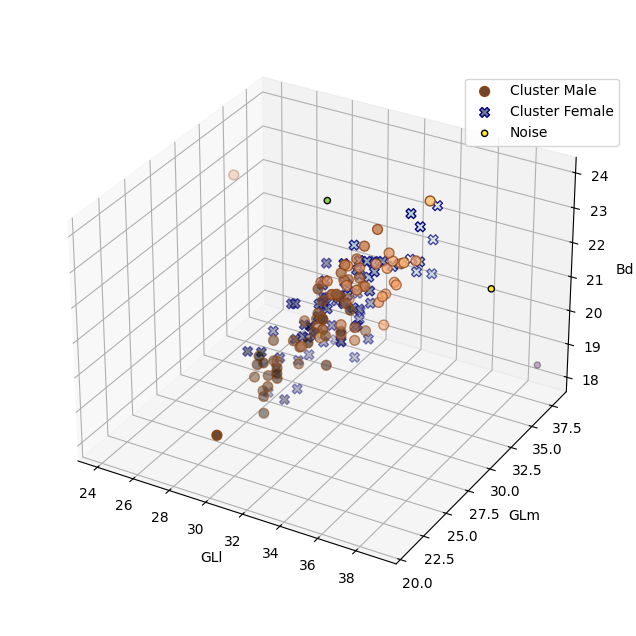

In [12]:
plt.rcParams['figure.figsize'] = [10, 8]

df_c1 = X_clusters.loc[X_clusters['Cluster'] == 0]
df_c2 = X_clusters.loc[X_clusters['Cluster'] == 1]
df_c3 = X_clusters.loc[X_clusters['Cluster'] == -1]
#df_pred_c1 = y_pred.loc[y_pred['y-pred'] == 0]
#df_pred_c2 = y_pred.loc[y_pred['y-pred'] == 1]

pltx = 'GLl'
plty = 'GLm'
pltz = 'Bd'
pltq = 'Dl'

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.set_box_aspect(aspect=None, zoom=0.92)

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

sctt = ax.scatter3D(df_c1[pltx], df_c1[plty], df_c1[pltz], c = df_c1[pltq], cmap = plt.get_cmap('copper'), marker='o', edgecolors='saddlebrown', s=50, label='Cluster Male')
sctt2 = ax.scatter3D(df_c2[pltx], df_c2[plty], df_c2[pltz], c = df_c2[pltq], cmap = plt.get_cmap('bone'), marker='X', edgecolors='navy', s=50, label ='Cluster Female')
sctt3 = ax.scatter3D(df_c3[pltx], df_c3[plty], df_c3[pltz], c = df_c3[pltq], cmap = plt.get_cmap('viridis'), marker='o', edgecolors='black', s=20, label ='Noise')

#sctt = ax.scatter3D(df_pred_c1[pltx], df_pred_c1[plty], df_pred_c1[pltz], c = df_pred_c1[pltq], cmap = plt.get_cmap('copper'), marker='^', edgecolors='green', s=80, label='Test Female')
#sctt2 = ax.scatter3D(df_pred_c2[pltx], df_pred_c2[plty], df_pred_c2[pltz], c = df_pred_c2[pltq], cmap = plt.get_cmap('winter'), marker='v', edgecolors='green', s=80, label='Test Male')

#plt.title("")
ax.set_xlabel(pltx, labelpad=5)
ax.set_ylabel(plty, labelpad=8)
ax.set_zlabel(pltz, labelpad=5)

ax.legend(bbox_to_anchor=(1, 0.9), bbox_transform=ax.transAxes)

#fig.colorbar(sctt, ax = ax, shrink = 0.8, label = pltq, pad=0)
#fig.colorbar(sctt2, ax = ax, shrink = 0.8, label = pltq, pad=0.1)
#fig.savefig('kMeans-Karakorum.pdf', bbox_inches='tight')

plt.show()

### k-Means

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

In [14]:
def perform_kMeans(X, y, n, rs):
    
    kmeans = KMeans(n_clusters=n, random_state=rs, n_init="auto").fit(X)
    #print(kmeans.labels_)
    labels = pd.DataFrame({'Label' : kmeans.labels_})
    #print(kmeans.cluster_centers_)

    X_clusters = pd.concat([X.reset_index(), labels], axis=1)
    
    if hasLabel:
        ari = adjusted_rand_score(y.to_numpy().flatten().astype(int), kmeans.labels_)
    else:
        ari = -1
    
    return X_clusters, ari

In [15]:
X_clusters, ari = perform_kMeans(X, y, 2, 100)
X_clusters

,index,GLl,GLm,Dl,Bd,Label
0,0,31.2,31.00,18.0,19.70,1
1,1,30.1,29.15,17.0,19.25,1
2,2,32.5,31.00,18.0,20.80,0
3,3,30.6,28.50,18.0,20.00,1
4,4,32.0,30.30,17.7,22.20,0
...,...,...,...,...,...,...
166,166,32.6,31.00,18.2,22.00,0
167,167,31.5,31.00,18.5,20.20,0
168,168,30.2,29.10,17.2,19.30,1
169,169,33.1,31.00,18.3,22.10,0


In [16]:
if hasLabel:
    kMeans_scores = []

    for i in range(100):
        X_clusters, ari = perform_kMeans(X, y, 2, i)
        kMeans_scores.append(ari)
    
    print(np.max(kMeans_scores))
    np.mean(kMeans_scores)

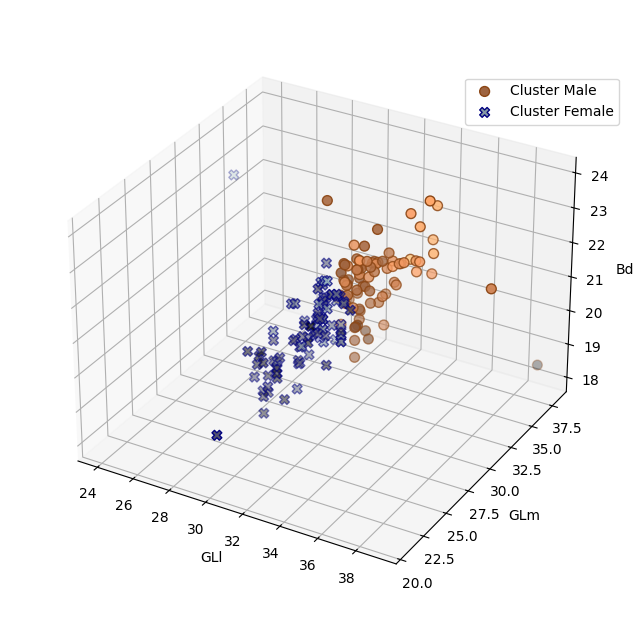

In [17]:
plt.rcParams['figure.figsize'] = [10, 8]

df_c1 = X_clusters.loc[X_clusters['Label'] == 0]
df_c2 = X_clusters.loc[X_clusters['Label'] == 1]
#df_pred_c1 = y_pred.loc[y_pred['y-pred'] == 0]
#df_pred_c2 = y_pred.loc[y_pred['y-pred'] == 1]

pltx = 'GLl'
plty = 'GLm'
pltz = 'Bd'
pltq = 'Dl'

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.set_box_aspect(aspect=None, zoom=0.92)

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

sctt = ax.scatter3D(df_c1[pltx], df_c1[plty], df_c1[pltz], c = df_c1[pltq], cmap = plt.get_cmap('copper'), marker='o', edgecolors='saddlebrown', s=50, label='Cluster Male')
sctt2 = ax.scatter3D(df_c2[pltx], df_c2[plty], df_c2[pltz], c = df_c2[pltq], cmap = plt.get_cmap('bone'), marker='X', edgecolors='navy', s=50, label ='Cluster Female')

#sctt = ax.scatter3D(df_pred_c1[pltx], df_pred_c1[plty], df_pred_c1[pltz], c = df_pred_c1[pltq], cmap = plt.get_cmap('copper'), marker='^', edgecolors='green', s=80, label='Test Female')
#sctt2 = ax.scatter3D(df_pred_c2[pltx], df_pred_c2[plty], df_pred_c2[pltz], c = df_pred_c2[pltq], cmap = plt.get_cmap('winter'), marker='v', edgecolors='green', s=80, label='Test Male')

#plt.title("")
ax.set_xlabel(pltx, labelpad=5)
ax.set_ylabel(plty, labelpad=8)
ax.set_zlabel(pltz, labelpad=5)

ax.legend(bbox_to_anchor=(1, 0.9), bbox_transform=ax.transAxes)

#fig.colorbar(sctt, ax = ax, shrink = 0.8, label = pltq, pad=0)
#fig.colorbar(sctt2, ax = ax, shrink = 0.8, label = pltq, pad=0.1)
fig.savefig('Karakorum-kMeans.pdf', bbox_inches='tight')

plt.show()

### DBScan

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

# Small Test on optimizing the epsilon
def dbScan_test(X, e, minPts, y=[]):
    db = DBSCAN(eps=e, min_samples=minPts).fit(X)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    if len(y)==0:
        ari=-1
    else:
        ari = adjusted_rand_score(y.to_numpy().flatten().astype(int), labels)
    return n_clusters_, n_noise_, ari


for e in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]:
    for minPts in [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        c, noise, ari = dbScan_test(X, e, minPts)
        if c == 2:
            print(f"Two Clusters found with {noise} Noise Points, epsilon={e} and minPts={minPts} and ARI={ari}.")

Two Clusters found with 161 Noise Points, epsilon=0.4 and minPts=4 and ARI=-1.
Two Clusters found with 157 Noise Points, epsilon=0.5 and minPts=5 and ARI=-1.
Two Clusters found with 158 Noise Points, epsilon=0.5 and minPts=6 and ARI=-1.
Two Clusters found with 153 Noise Points, epsilon=0.6 and minPts=8 and ARI=-1.
Two Clusters found with 147 Noise Points, epsilon=0.7 and minPts=10 and ARI=-1.
Two Clusters found with 37 Noise Points, epsilon=0.8 and minPts=3 and ARI=-1.
Two Clusters found with 40 Noise Points, epsilon=0.8 and minPts=4 and ARI=-1.
Two Clusters found with 115 Noise Points, epsilon=0.8 and minPts=12 and ARI=-1.
Two Clusters found with 127 Noise Points, epsilon=0.8 and minPts=13 and ARI=-1.
Two Clusters found with 129 Noise Points, epsilon=0.8 and minPts=14 and ARI=-1.
Two Clusters found with 29 Noise Points, epsilon=0.9 and minPts=3 and ARI=-1.
Two Clusters found with 29 Noise Points, epsilon=0.9 and minPts=4 and ARI=-1.
Two Clusters found with 32 Noise Points, epsilon=0.9

In [19]:
db = DBSCAN(eps=0.9, min_samples=4).fit(X)   #1.2 - 14
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters:", n_clusters_)
print("Estimated number of noise points:", n_noise_)

#print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")
#print("ARI score:", adjusted_rand_score(y.to_numpy().flatten().astype(int), db.labels_))

Estimated number of clusters: 2
Estimated number of noise points: 29


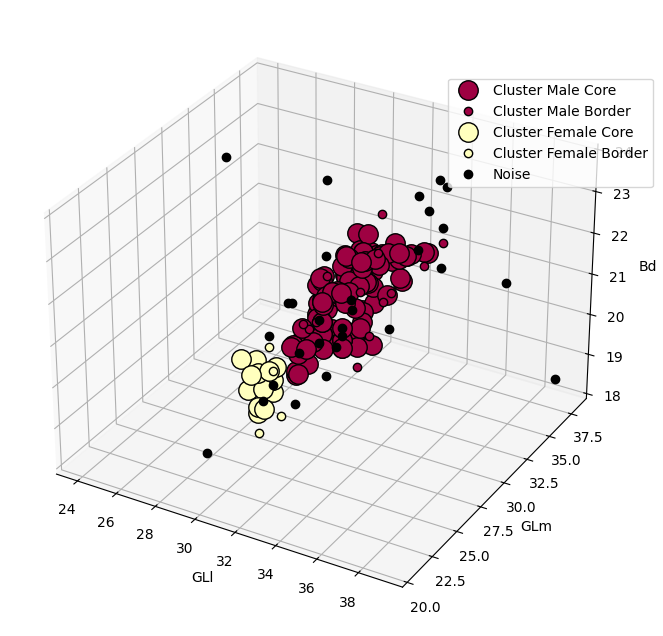

In [20]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) #(16.0, 13.0)

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

fig = plt.figure()
ax = plt.axes(projection ="3d")

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    #print(xy['GLl'])
    plt.plot(
        xy['GLl'],
        xy['GLm'],
        xy['Bd'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy['GLl'],
        xy['GLm'],
        xy['Bd'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6
    )

#plt.title(f"Estimated number of clusters: {n_clusters_}")
ax.set_xlabel('GLl')
ax.set_ylabel('GLm')
ax.set_zlabel('Bd')

ax.legend(['Cluster Male Core', 'Cluster Male Border', 'Cluster Female Core', 'Cluster Female Border', '_1', 'Noise'], bbox_to_anchor=(0.7, 0.9), bbox_transform=ax.transAxes)

#fig.colorbar(sctt, ax = ax, shrink = 0.8, label = pltq)
plt.savefig('Karakorum-DBScan.pdf', bbox_inches='tight')
plt.show()

In [21]:
# Print Outlier

#print(len(X))
#print(len(labels))

df_labels = pd.DataFrame(labels, columns = ['DBScanLabel'])
df_labels = pd.concat([X, df_labels], axis=1)

df_outlier = df_labels.loc[df_labels['DBScanLabel'] == -1]
print(df_outlier)

# Save to file
#df_outlier.to_csv('DBScan-Karakorum-outlier.csv', sep=';', index=True)

      GLl   GLm    Dl    Bd  DBScanLabel
0    31.2  31.0  18.0  19.7           -1
3    30.6  28.5  18.0  20.0           -1
14   38.8  32.5  18.8  22.0           -1
17   34.5  32.5  19.5  23.5           -1
27   34.5  32.5  20.5  22.2           -1
34   29.5  27.0  17.0  19.0           -1
46   29.2  28.2  17.8  20.3           -1
50   29.9  27.2  16.3  19.4           -1
61   35.0  32.5  19.8  23.2           -1
70   31.3  32.3  18.3  20.6           -1
77   31.7  29.0  16.5  19.5           -1
80   30.6  31.2  17.3  21.8           -1
82   33.3  32.1  18.8  20.2           -1
86   35.5  32.5  19.7  24.0           -1
98   30.5  28.2  17.4  18.8           -1
110  30.0  20.8  17.0  19.2           -1
112  31.5  28.7  17.0  20.9           -1
119  35.0  34.0  20.0  22.5           -1
124  32.5  30.0  16.5  21.0           -1
125  29.8  29.0  17.5  21.0           -1
129  30.1  28.8  17.5  21.1           -1
132  39.0  38.0  15.5  18.5           -1
140  32.0  30.0  16.5  20.3           -1
141  31.0  30.5 

In [22]:
df_ohneOutlier = pd.merge(X, df_outlier[['GLl', 'Bd', 'GLm', 'Dl']], indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
print(f"Original Dataframe length: {len(X)} and without outliers: {len(df_ohneOutlier)}")
print(df_ohneOutlier.head())

Original Dataframe length: 171 and without outliers: 142
    GLl    GLm    Dl     Bd
1  30.1  29.15  17.0  19.25
2  32.5  31.00  18.0  20.80
4  32.0  30.30  17.7  22.20
5  31.5  30.50  18.0  21.00
6  30.6  30.20  17.7  20.20


In [23]:
df_ohneOutlier.to_pickle("./data/Karakorum-NoOutlier.pkl")

### Redo All without Outlier

In [24]:
db = DBSCAN(eps=0.9, min_samples=4).fit(df_ohneOutlier)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 0


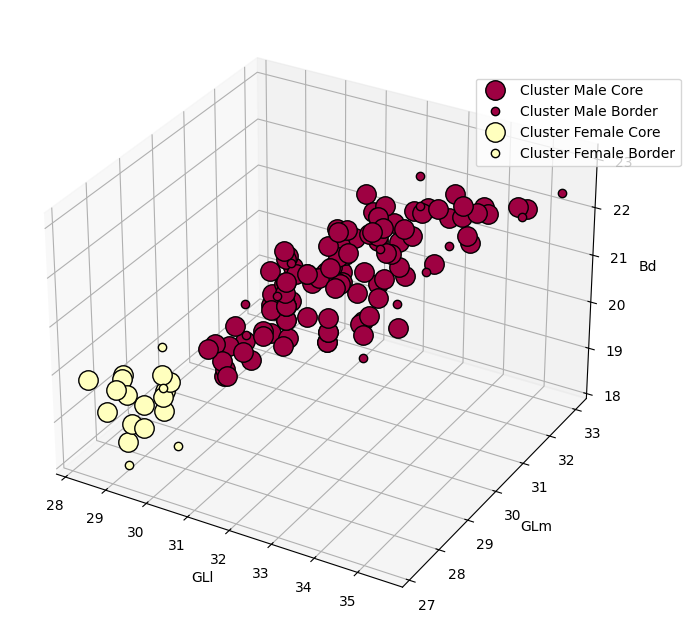

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

fig = plt.figure()
ax = plt.axes(projection ="3d")

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels)+1)]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = df_ohneOutlier[class_member_mask & core_samples_mask]
    #print(xy['GLl'])
    plt.plot(
        xy['GLl'],
        xy['GLm'],
        xy['Bd'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14
    )

    xy = df_ohneOutlier[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy['GLl'],
        xy['GLm'],
        xy['Bd'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6
    )

#plt.title(f"Estimated number of clusters: {n_clusters_}")
ax.set_xlabel('GLl')
ax.set_ylabel('GLm')
ax.set_zlabel('Bd')

ax.legend(['Cluster Male Core', 'Cluster Male Border', 'Cluster Female Core', 'Cluster Female Border', '1', 'Noise'], bbox_to_anchor=(1.1, 0.9), bbox_transform=ax.transAxes)

#fig.colorbar(sctt, ax = ax, shrink = 0.8, label = pltq)
#plt.savefig('DBScan-Karakorum.png', bbox_inches='tight')
plt.show()

In [26]:
from sklearn.mixture import GaussianMixture

In [27]:
gmm = GaussianMixture(n_components=2).fit(df_ohneOutlier)
gmm_classes = gmm.predict(df_ohneOutlier)
gmm_labels = pd.DataFrame({'Label' : gmm_classes})

prob = gmm.predict_proba(df_ohneOutlier)
prob0 = result = [t[0] for t in prob]
gmm_prob0 = pd.DataFrame({'Prob0' : prob0})
prob1 = result = [t[1] for t in prob]
gmm_prob1 = pd.DataFrame({'Prob1' : prob1})

X_clusters = pd.concat([df_ohneOutlier.reset_index(), gmm_labels, gmm_prob0, gmm_prob1], axis=1)

X_clusters
#ari = adjusted_rand_score(y.to_numpy().flatten().astype(int), gmm_labels)

,index,GLl,GLm,Dl,Bd,Label,Prob0,Prob1
0,1,30.1,29.15,17.0,19.25,0,9.566709e-01,0.043329
1,2,32.5,31.00,18.0,20.80,1,2.918296e-02,0.970817
2,4,32.0,30.30,17.7,22.20,1,2.484377e-02,0.975156
3,5,31.5,30.50,18.0,21.00,1,2.198621e-01,0.780138
4,6,30.6,30.20,17.7,20.20,0,8.203988e-01,0.179601
...,...,...,...,...,...,...,...,...
137,165,35.5,33.00,20.0,22.40,1,5.293747e-08,1.000000
138,166,32.6,31.00,18.2,22.00,1,1.483715e-02,0.985163
139,168,30.2,29.10,17.2,19.30,0,9.554792e-01,0.044521
140,169,33.1,31.00,18.3,22.10,1,2.406009e-03,0.997594


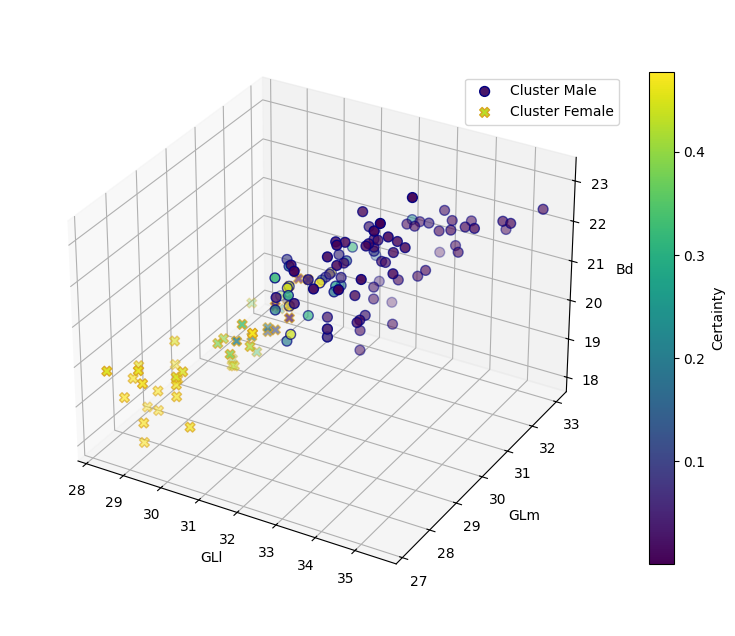

In [28]:
plt.rcParams['figure.figsize'] = [10, 8]

df_c1 = X_clusters.loc[X_clusters['Label'] == 1]
df_c2 = X_clusters.loc[X_clusters['Label'] == 0]
#df_pred_c1 = y_pred.loc[y_pred['y-pred'] == 0]
#df_pred_c2 = y_pred.loc[y_pred['y-pred'] == 1]

pltx = 'GLl'
plty = 'GLm'
pltz = 'Bd'
pltq = 'Prob0'

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.set_box_aspect(aspect=None, zoom=0.92)

ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.3, alpha = 0.2)

sctt = ax.scatter3D(df_c1[pltx], df_c1[plty], df_c1[pltz], c = df_c1[pltq], cmap = plt.get_cmap('viridis'), marker='o', edgecolors='navy', s=50, label='Cluster Male')
sctt2 = ax.scatter3D(df_c2[pltx], df_c2[plty], df_c2[pltz], c = df_c2[pltq], cmap = plt.get_cmap('viridis'), marker='X', edgecolors='goldenrod', s=50, label ='Cluster Female')

#sctt = ax.scatter3D(df_pred_c1[pltx], df_pred_c1[plty], df_pred_c1[pltz], c = df_pred_c1[pltq], cmap = plt.get_cmap('copper'), marker='^', edgecolors='green', s=80, label='Test Female')
#sctt2 = ax.scatter3D(df_pred_c2[pltx], df_pred_c2[plty], df_pred_c2[pltz], c = df_pred_c2[pltq], cmap = plt.get_cmap('winter'), marker='v', edgecolors='green', s=80, label='Test Male')

#plt.title("")
ax.set_xlabel(pltx, labelpad=5)
ax.set_ylabel(plty, labelpad=8)
ax.set_zlabel(pltz, labelpad=5)

ax.legend(bbox_to_anchor=(1, 0.9), bbox_transform=ax.transAxes)

fig.colorbar(sctt, ax = ax, shrink = 0.8, label = 'Certainty', pad=0.03)
#fig.colorbar(sctt2, ax = ax, shrink = 0.8, label = pltq, pad=0.1)
fig.savefig('Karakorum-GMM.pdf', bbox_inches='tight')

plt.show()